,keyword,frequency
0,hn,211
1,google,194
2,show,192
3,new,188
4,open,126
5,bitcoin,106
6,web,99
7,programming,91
8,data,87
9,source,86


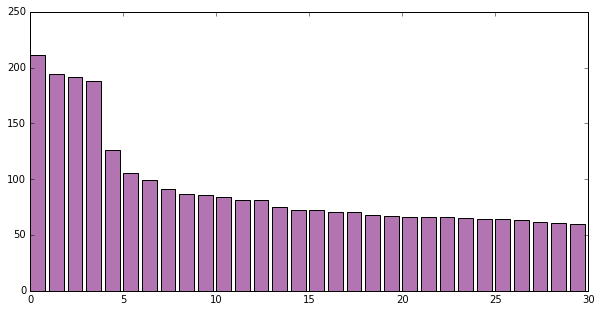

In [48]:
from pipeline import Pipeline 
import json 
import io
from datetime import datetime
import csv
import string
import re
import itertools
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

def build_csv(lines, header=None, file=None):
    if header:
        lines = itertools.chain([header], lines)
    writer = csv.writer(file, delimiter=',')
    writer.writerows(lines)
    file.seek(0)
    return file

pipeline = Pipeline() 

@pipeline.task()
def file_to_json():
    with open('hn_stories_2014.json','r') as file:
        json_data = json.load(file)
        stories = json_data['stories']
        
    return stories

@pipeline.task(depends_on = file_to_json)
def filter_stories(stories):
    def most_pop(story):
        return story['points'] > 50 and story['num_comments'] > 1 and not story['title'].startswith('Ask HN')
        
    return (s for s in stories if most_pop(s))


@pipeline.task(depends_on = filter_stories)
def json_to_csv(stories):
    header = ['objectID','created_at','url','points','title']
    story_list = []
    
    for s in stories:
        story_list.append([s['objectID'], datetime.strptime(s['created_at'], "%Y-%m-%dT%H:%M:%SZ"),\
                     s['url'], s['points'], s['title']])
    
    return build_csv(story_list, header = header, file = io.StringIO())


@pipeline.task(depends_on = json_to_csv)
def extract_titles(file_obj):
    reader = csv.reader(file_obj)
    header = next(reader)
    i =  header.index('title')
    return (line[i] for line in reader)


@pipeline.task(depends_on = extract_titles)
def clean_titles(titles):
    
    for title in titles:
        title = title.lower()
        title = re.sub('[^A-Za-z]',' ', title)
        yield title
    

@pipeline.task(depends_on = clean_titles)
def build_keyword_dictionary(titles):
    word_dict = {}
    for title in titles:
        for word in title.split(" "):
            if word and word not in stopwords:
                if word not in word_dict:
                    word_dict[word] = 0
                word_dict[word] += 1
    return word_dict
    

@pipeline.task(depends_on=build_keyword_dictionary)
def top_keywords(word_freq):
    key = [[k,word_freq[k]] for k in sorted(word_freq, key=word_freq.__getitem__, reverse=True)]
    return pd.DataFrame(key, columns=['keyword','frequency'])

@pipeline.task(depends_on=top_keywords)
def barplot30(df):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.bar(range(len(df.iloc[0:30,0])), df.iloc[0:30,1],color = (0.5,0.1,0.5,0.6) )

ran = pipeline.run()
ran[top_keywords][:30]
